In [559]:
# use qpcr conda environment
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
import seaborn as sns
from statannotations.Annotator import Annotator
import os
from scipy import stats
#cycle through alphabet
from string import ascii_uppercase as alc

In [560]:
#need to add ARF plots into subplots for each promoter - make them on a row of 3 plots

In [561]:
#function to read in data
def read_data(file):
    data = pd.read_csv(file, sep='\t', header=0)
    return data

In [562]:
#make plot
def make_plot(prom,TF,df,order, pair, fontsize,ax,folder,plot_title=None):
    """function to make and save plots"""
    # plt.figure(figsize=(fig_width,fig_height))
    
    #order_new = pair[0]
    fig_args = {'x':'TF_added', 'y':'corrected_luminescence','data':df, 'order':order, 'dodge':True,}#'ax':ax
    configuration = {'test':'t-test_welch', 'text_format':'star', 'pvalue_thresholds':[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1, "ns"]]}#"pairs":list(box_pairs_significant.keys()),"pvalues":list(box_pairs_significant.values()), 'loc':'inside'
    sns.barplot(**fig_args, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,color='lightgrey',ax=ax)#facecolor=(1,1,1,1),
    #fig.set_aspect(0.5)color='#BFBFBF'
    sns.swarmplot(**fig_args,color='black',ax=ax, size=3)
    #add stats
    annotator = Annotator(ax, pair, **fig_args,verbose=False, show_non_significant=False)
    annotator.configure(**configuration)#loc='inside'
    ax, test_results = annotator.apply_and_annotate()
    with open(f'../../../../data/plots/luminescence/{folder}/individual/stats.txt', 'a') as f:                            
        for res in test_results:
            f.write(f'{str(prom)},{pair},{str(res.data)}\n')
    # change axes labels
    ax.set_ylabel('Normalised expression (a.u.)')
    ax.set_xlabel('TF added')
    #rotate axes labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    #colour list
    # colour_dict = {'ANAC032':'#d55e00','DREB26':'#e69f00','ANR1':'#3DB7E9','TGA1':'#F748A5','NLP6':'#228833','NLP7':'#228833',}
    #     '#2271B2',#ARF9/18
#     '#d55e00',#ANAC032
#     '#e69f00',#DREB26
#     '#3DB7E9',#ANR1
     
    
    
    
#     '#F748A5',#TGA1
    
#     '#228833',#NLP6/7
    
#     #'#f0e442',
    
#     '#900000',]
    # #change bar fill colour depending on TF added
    # for i,bar in enumerate(ax.patches):
        
    #     if TF in colour_dict:
    #         bar.set_facecolor(colour_dict[TF])
    #     if TF not in colour_dict:
    #         bar.set_facecolor('#21165800')
            

    # ax.set_title(plot_title)
    #add title
    #plt.title(prom[:len(prom)-20], y=1,size=fontsize)
    if plot_title==None:
        pass
        # ax.set_title(f'Co-expression\n 35s:{TF[1:]} + {prom}p:LucN', y=1,size=fontsize)
    if plot_title!=None:
        ax.set_title(plot_title, y=1,size=fontsize)

    # #if ARFs = True:
    # if ARFs==True:
    #     pass
    

    
    #make subplot xticks diagonal 

    # ax.set_xticklabels(, rotation=90, ha="right",rotation_mode="anchor")
    # plt.xticks(rotation=90, ha='center')#ha='right'
    #plt.xlabel(x_label)
    # tight layout
    # plt.tight_layout()
    # save figure
    
    #don't show plot in notebook
    # plt.cla()  # clear axis              
    # plt.close('all')    

In [563]:
#make plot
def make_plot_arfs(prom,TF,df,TFs_orig,TF_order, fontsize,ax,folder,plot_title=None):
    """function to make and save plots"""
    # plt.figure(figsize=(fig_width,fig_height))
    #filter df to only include TFs in TF_order
    df = df[df['TF_added'].isin(TF_order)]
   
    #sort based on custom order
    TFs = []
    for i in range(len(TF_order)):
        if TF_order[i] in TFs_orig:
            TFs+=[TF_order[i]]
    # print(TFs_orig)
    # print(TF_order)
    # print(TFs)
    #filter df to only include TFs in TFs_new
    #df = df[df['TF_added'].isin(TFs)]
    #refine to specific date 
    current_prom_tf_date = df[df['TF_added']==TF]['date'].unique()
    #filter TF_df by date
    df = df[df['date'].isin(current_prom_tf_date)]
    #refine to specific well calibrator
    # df = df[df['Well_calibrator']=='NOS_LucF']
    current_prom_tf_well_calibrator = df[df['TF_added']==TF]['Well_calibrator'].unique()
    #filter TF_df by well calibrator
    df = df[df['Well_calibrator'].isin(current_prom_tf_well_calibrator)]
    # print(df)
    
    #get length of number of TFs
    length_tf = len(TFs)
    # print(f'length_tf={length_tf}')
    if length_tf <= 1:
        pass
    else:
        #create order and box pairs based on the length of TFs
        order = []
        box_pairs = []   
        for x in range (0, (length_tf)):
            order.append(TFs[x])
            if TFs[x] == "No TF" or TFs[x] == "No TF_1μM_NAA":
                pass
            #if auxin condition, use auxin control
            elif "_1μM_NAA" in TFs[x]:
                box_pairs.append(('No TF_1μM_NAA',TFs[x]))

            else:
                box_pairs.append(('No TF',TFs[x]))
        box_pairs_all_pvalues = {}
        #make dict containing the TF and p value compared to its control (either No TF with auxin or no auxin No TF)
        TFs_pvalues = {}
        for pair in box_pairs:
            #create series objects
            TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
            TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']

            #equal variance = false so do Welch's T-test
            results = stats.ttest_ind(TF1, TF2, equal_var=False)
            #append pvalue to dict
            box_pairs_all_pvalues[pair] = results.pvalue
            TFs_pvalues[pair[1]] = results.pvalue
    # #filter dict by significance and put in a new dictionary
        box_pairs_significant = {}
        for k,v in box_pairs_all_pvalues.items():
            if v <0.05:
                box_pairs_significant[k] = v

        def convert_pvalue_to_asterisks(pvalue):
            if pvalue <= 0.001:
                return "***"
            elif pvalue <= 0.01:
                return "**"
            elif pvalue <= 0.05:
                return "*"
            return "ns"
        if length_tf == 2:
            #plt.figure()
            # plt.figure(figsize=(length_tf*0.8,8))
            #order_new = [TFs[0],TFs[1]]
            
            sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4, dodge=True, color='#BFBFBF',ax=ax)#facecolor=(1,1,1,1),
            # change_width(fig, bar_width)
            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True,ax=ax)
        
        elif length_tf < 2:
            pass
        else:
            # print(prom)
            # print(TFs)
            # plt.figure(figsize=(length_tf,8))
            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,dodge=True, color='lightgrey',ax=ax)#facecolor=(1,1,1,1)
            # change_width(fig, bar_width)
            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True,ax=ax)
            #get x length
            xlength=len(ax.patches)
            auxin_control_picked = False
            for x in range (0, (xlength)):
                current_TF = order[x]
                if current_TF == "No TF" or current_TF == '':                
                    pass
                elif current_TF == "No TF_1μM_NAA":
                    auxin_control_picked = True                    
                # hatch = next(hatches)
                    ax.patches[x].set_facecolor('grey')
                else:
                    pvalue = TFs_pvalues[current_TF]

                    
                # pvalue = list(box_pairs_all_pvalues.values())[x]
                    #key=list(box_pairs_all_pvalues.keys())[x][1]
                    p = ax.patches[x]
                    ax.annotate(convert_pvalue_to_asterisks(pvalue),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    size=fontsize,
                    xytext = (0, 10), 
                    textcoords = 'offset points')
                    #add patterned hatching to the bars length_tf
                    if auxin_control_picked == True:
                        
                        p.set_facecolor('grey')
        #add custom legend
        handles = []
        labels = []
        no_auxin = mpatches.Patch(facecolor='lightgrey', hatch='',edgecolor='black',linewidth=2)
        auxin = mpatches.Patch(facecolor='grey', hatch='',edgecolor='black',linewidth=2)
        no_auxin_label = "No NAA"
        auxin_label = "1 µM NAA"
        handles.append(no_auxin)
        handles.append(auxin)
        labels.append(no_auxin_label)
        labels.append(auxin_label)
        
        
        ax.legend(handles=handles,labels=labels,ncol=1,bbox_to_anchor=(0.1,0.85), loc='lower left',fontsize=fontsize*0.7,frameon=False,)
        #add new labels
        #if TF in new_labels is 'ARF18+ARF9' then change to 'ARF9/18', also remove _1μM_NAA if necessary
        new_labels = []        
        for TF in order:
            if '_1μM_NAA' in TF:
                TFs_orig_renamed = TF[:len(TF)-8]
                if TFs_orig_renamed == 'ARF18+ARF9':
                    TFs_orig_renamed = 'ARF9/18'
                new_labels.append(TFs_orig_renamed)
            else:
                if TF == 'ARF18+ARF9':
                    TF = 'ARF9/18'
                new_labels.append(TF)

       
                
        ax.set_xticklabels(new_labels)
        # change axes labels
        ax.set_ylabel('Normalised expression (a.u.)')
        #add title
        # plt.title(prom, y=1,size=fontsize)
        #make xticks diagonal
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
        

In [564]:
#function to make subplots and iterate over promoters
def make_subplots(df,fontsize,TFs_of_interest,folder):
    """function to make subplots"""
    
    # get prom_names as list
    df_unfiltered = df.copy()
    #filter df to exclude TFs in filter_tf_list

    filter_tf_list = ['ARF9','ARF18','ARF18+ARF9','ARF9_1μM_NAA','ARF18_1μM_NAA','ARF18+ARF9_1μM_NAA','No TF_1μM_NAA']#'ARF18+IAA33_1μM_NAA','ARF18+IAA33'
    df = df[~df['TF_added'].isin(filter_tf_list)]

    proms = list(df['Promoter'].unique())
    
    #divide number of subplots by 4 to get number of rows
    
    #iterate over promoters
    for prom in proms:
        # print(f'prom={prom}')
        
      
    
        #get list of TFs for each promoter
        TFs_orig = df[df['Promoter']==prom]['TF_added'].unique()
        TFs_orig_unfiltered = df_unfiltered[df_unfiltered['Promoter']==prom]['TF_added'].unique()
        #sort TFs alphabetically
        #TFs_orig = sorted(TFs_orig)
        #assign list of TFs of interest with this well calibrator
        # print(f'TFs_of_interest={TFs_of_interest}')
        #sort based on custom order
        #exclude items in this list from TFs
        
        TFs = []
        for i in range(len(TFs_of_interest)):
            if TFs_of_interest[i] in TFs_orig:
                # print(f'TFs_of_interest[i]={TFs_of_interest[i]}')
                TFs+=[TFs_of_interest[i]]

        #sort alphabetically, ignoreing case
        TFs = sorted(TFs, key=str.lower)
        # print(f'TFs={TFs}')
        # print(f'TFs_orig={TFs_orig}')
        filter_tf_list = ['No TF','ARF9','ARF18','ARF18+ARF9','ARF9_1μM_NAA','ARF18_1μM_NAA','ARF18+ARF9_1μM_NAA']
        #filter TFs
        TFs_for_subplots = [x for x in TFs if x not in filter_tf_list]
        #define number of subplots
        
        number_of_subplots = len(TFs_for_subplots)+1
        #make subplots for each promoter
        number_of_rows = math.ceil(number_of_subplots/4)+1
        height = 4.8*number_of_rows
        width = 10
        #make subplots equal to number_of_subplots
        #fig = plt.figure(constrained_layout=True)
        fig, axes = plt.subplots(nrows=number_of_rows, ncols=4, figsize=(width, height), sharex=False)
        
        #flatten axis array
        axes = axes.flatten()
        axes_count = 0
        #make promoter df
        promoter_df = df[df['Promoter']==prom]
        #make promoter df unfiltered
        promoter_df_unfiltered = df_unfiltered[df_unfiltered['Promoter']==prom]
        #iterate over TFs

        for TF in TFs_for_subplots:
            if TF != 'No TF' and TF != 'ARF9' and TF != 'ARF18' and TF != 'ARF18+ARF9' and TF != 'ARF9_1μM_NAA' and TF != 'ARF18_1μM_NAA' and TF != 'ARF18+ARF9_1μM_NAA':
                # print(f'TF={TF}')
                # print(f'axes_count={axes_count}')
                
                #get data for each TF
                
                TF_df = promoter_df[(promoter_df['TF_added']==TF)|(promoter_df['TF_added']=='No TF')]
                #refine to specific date 
                current_prom_tf_date = TF_df[TF_df['TF_added']==TF]['date'].unique()
                #filter TF_df by date
                TF_df = TF_df[TF_df['date'].isin(current_prom_tf_date)]
                #refine to specific well calibrator
                current_prom_tf_well_calibrator = TF_df[TF_df['TF_added']==TF]['Well_calibrator'].unique()
                #filter TF_df by well calibrator
                TF_df = TF_df[TF_df['Well_calibrator'].isin(current_prom_tf_well_calibrator)]
                #print(TF_df)
                


                #define pair and order
                pair = [('No TF', TF)]
                order= pair[0]
                
                # order = ['No TF',TF]
                # pair = [TF,'No TF']
                #make plot
                make_plot(prom,TF,TF_df,order, pair, fontsize,axes[axes_count],folder)
                axes_count+=1
        #at the end make plot xticks 90 edgrees
        # plt.xticks(rotation=90, ha='center')
        #add plot labels
        letter_count = 1
        for ax in axes:
            
            #if letter_count is higher than number of subplots, remove axis
            if letter_count >= number_of_subplots:
                ax.axis('off')
                # letter_count += 1
            else:
                letter = alc[letter_count]
                ax.text(-0.1, 1.2, letter, transform=ax.transAxes, fontsize=18,  va='top', ha='right')#fontweight='bold'
                letter_count += 1

        #save figures
        plt.tight_layout()
        plt.savefig(
            f'../../../../data/plots/luminescence/{folder}/individual/{prom}_barplot.pdf',
            format="pdf",
            bbox_inches="tight",transparent=True)
        plt.savefig(
            f'../../../../data/plots/luminescence/{folder}/individual/{prom}_barplot.svg',
            format="svg",
            bbox_inches="tight",transparent=True)
        #remove plot
        plt.cla()  # clear axis
        plt.close('all')
        #make new plot
        height = 6
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(width, height), sharex=False)
        #flatten axis array
        axes = axes.flatten()
        axes_count = 0

        #make ARF9 plot
        TF_order_arf9 = ['No TF','ARF9','No TF_1μM_NAA','ARF9_1μM_NAA']
        make_plot_arfs(prom,'ARF9',promoter_df_unfiltered,TFs_orig_unfiltered,TF_order_arf9,fontsize,axes[axes_count],folder)
        axes_count+=1

        TF_order_arf18 = ['No TF','ARF18','No TF_1μM_NAA','ARF18_1μM_NAA']
        make_plot_arfs(prom,'ARF18',promoter_df_unfiltered,TFs_orig_unfiltered,TF_order_arf18,fontsize,axes[axes_count],folder)
        axes_count+=1

        TF_order_arf9_18 = ['No TF','ARF18+ARF9','No TF_1μM_NAA','ARF18+ARF9_1μM_NAA']
        make_plot_arfs(prom,'ARF18+ARF9',promoter_df_unfiltered,TFs_orig_unfiltered,TF_order_arf9_18,fontsize,axes[axes_count],folder)
        axes_count+=1

        #add plot labels
        # letter_count = 1
        number_of_subplots += 3
        for ax in axes:
            
            # #if letter_count is higher than number of subplots, remove axis
            # if letter_count >= number_of_subplots:
            #     ax.axis('off')
            #     letter_count += 1
            # else:
            letter = alc[letter_count]
            ax.text(-0.1, 1.2, letter, transform=ax.transAxes, fontsize=18,  va='top', ha='right')#fontweight='bold'
            letter_count += 1
        #save figures    
        plt.tight_layout()
        plt.savefig(
            f'../../../../data/plots/luminescence/{folder}/individual/{prom}_barplot_arfs.pdf',
            format="pdf",
            bbox_inches="tight",transparent=True)
        plt.savefig(
            f'../../../../data/plots/luminescence/{folder}/individual/{prom}_barplot_arfs.svg',
            format="svg",
            bbox_inches="tight",transparent=True)
        #make plot
        # make_plot(prom,TF,df,order, pair, fig_width, fig_height,bar_width, fontsize,axes[axes_count],plot_title)
        #increase axes count
        # axes_count+=1


    

In [565]:
#set matplotlib rc parameters
def set_rc_params():
    #set matplotlib default parameters
    rcParams['xtick.major.width'] = 2
    rcParams['ytick.major.width'] = 2
    rcParams['axes.linewidth'] = 2
    rcParams['lines.linewidth'] = 2
    #remove top and right lines
    rcParams['axes.spines.top'] = False
    rcParams['axes.spines.right'] = False
    #font size
    fontsize = 20
    rcParams['font.size'] = fontsize
    #for getting the microsoft font Arial working, please follow this guide: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Arial']
    #allow font to be edited later in pdf editor
    #make svg text editable
    rcParams['svg.fonttype'] = 'none'
    rcParams ['pdf.fonttype'] = 42 
    #align y-axis top most tick with end of axis
    rcParams['axes.autolimit_mode'] = 'round_numbers'
    #set margins to ensure any error bars fit
    rcParams['axes.xmargin'] = 0.2
    rcParams['axes.ymargin'] = 0.2
    #define bar width
    #bar_width = 0.65
    #allow math text to be displayed
    #rcParams['mathtext.default'] = 'regular'
    return fontsize
    

In [566]:
#main function
def main():
    #data location
    data_dir = '../../../../data/plots/luminescence/all_combined/coexpression_data_native.tsv'
    #read in tsv
    df = read_data(data_dir)
    #delete the stats file if it exists
    stats_file = '../../../../data/plots/luminescence/all_combined/individual/stats.txt'
    if os.path.exists(stats_file):
        os.remove(stats_file)
    

    

    #make new folder
    #create individual plot folder name
    #make directory for the plots to be exported to
    dirName = f'../../../../data/plots/luminescence/all_combined/individual'
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " created") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")
    

    
    
    #make plots
    
    fontsize = set_rc_params()
    
   
    

    TFs_of_interest = ['No TF','ANAC032','ANR1','bZIP3','DREB26','HHO2','NLP6','NLP7','TGA1','ARF9','ARF18','ARF18+ARF9','ARF9_1μM_NAA','ARF18_1μM_NAA','ARF18+ARF9_1μM_NAA']
    #filter out if TF_Added is item in filter_tf_list


    #df_filtered = df_filtered[~df_filtered['TF_added'].isin(filter_tf_list)]
    make_subplots(df, fontsize, TFs_of_interest,'all_combined')



Directory  ../../../../data/plots/luminescence/all_combined/individual  already exists


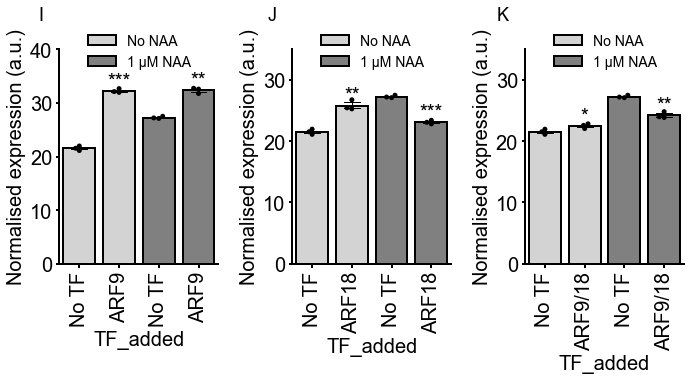

In [567]:
#main function call
if __name__ == '__main__':
    main()